# Demo of Behaviour Analysis for Keypoint Data
This notebook demonstrates a pipeline for turning keypoint data gathered from deep learning models into scientifically useful data and visualizations. It includes an image registration step that removes scale and position variance between videos, allowing for perfectly aligned analysis not available in existing commercial or open source tools. 

Author: Andre Telfer (andretelfer@cmail.carleton.ca) - currently looking to collaborate on behavioral analysis pipelines.

## Background
Advances in Deep Learning have driven a wave of pose-estimation tools which extract information from animals and their surroundings ([DeepLabCut](http://www.mackenziemathislab.org/deeplabcut), [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose), [SLEAP](https://sleap.ai/)). These models are trained to extract keypoint data (x, y coordinates) for specified bodyparts or objects in the environment.


## Installation


In [1]:
pip install -U -q bapipe-keypoints-telfer

Note: you may need to restart the kernel to use updated packages.


To install the local code 
```python
pip install --upgrade --no-deps --force-reinstall ..
```

## Structure of Data
In order to use this pipeline, load a csv file with the following information
- subject id
- path to video
- path to mouse bodypart position files (produced from DeepLabCut or similar pose estimation software) 
- path to video landmarks (e.g. box corners) [optional]
- path to camera calibrations [optional]

In [ ]:
%%time
import pandas as pd
from pathlib import Path

PROJECT = Path("/home/jovyan/shared/shared/curated/fran/v2")

datafiles = pd.read_csv(PROJECT / 'datafiles.csv')
datafiles.head(3)

CPU times: user 378 ms, sys: 1.03 s, total: 1.41 s
Wall time: 210 ms


,id,video,mouse_labels,landmark_labels,camera_calibrations
0,m1,videos/m1.mp4,videos/mouse_labels/m1DLC_resnet50_agrpNov19sh...,videos/landmark_labels/m1DLC_resnet50_agrp_lan...,camera_calibrations.json
1,m2,videos/m2.mp4,videos/mouse_labels/m2DLC_resnet50_agrpNov19sh...,videos/landmark_labels/m2DLC_resnet50_agrp_lan...,camera_calibrations.json
2,m3,videos/m3.mp4,videos/mouse_labels/m3DLC_resnet50_agrpNov19sh...,videos/landmark_labels/m3DLC_resnet50_agrp_lan...,camera_calibrations.json


## Load Experiment
- Normalize videos
  - Register arena corners
  - Remove lens warping
  - Clip start time for when mouse is first visible
- Outlier correction 
  - Remove based on pairwise distances
  - Remove based on bodypart velocities
- Provide an api for common operations
  - Parallelized analysis to reduce run times by several times
  - Provides visibility for common features

In [4]:
%%time 
import numpy as np
import bapipe

config = bapipe.AnalysisConfig(
    box_shape=(400, 300),            # size of the box in mm (or any other units)
    remove_lens_distortion=True,     # remove distortion caused by camera lens (requires a calibration file)
    use_box_reference=True,          # align all of the videos for the test arena
)

video_set = bapipe.VideoSet.load(datafiles, config, root_dir=PROJECT)
video_set

100%|████████████████████████████████████████████████████████| 72/72 [00:09<00:00,  7.63it/s]


CPU times: user 1.83 s, sys: 737 ms, total: 2.57 s
Wall time: 10.1 s


Number of videos,72
"Video sizes (W,H)",960x540
Total duration [s],47837.6
Average duration [s],664.41


## Compare original videos to corrected videos

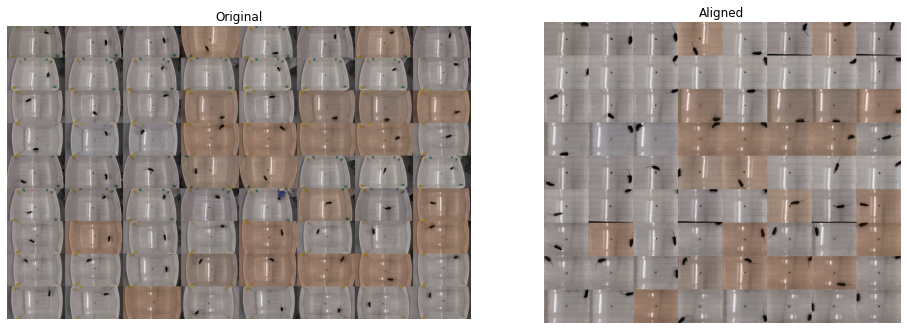

CPU times: user 45.3 s, sys: 5.51 s, total: 50.9 s
Wall time: 8.9 s


In [5]:
%%time 
import matplotlib.pyplot as plt

gs = plt.GridSpec(1, 100)
plt.figure(figsize=(16,10))

plt.subplot(gs[:52])
plt.title("Original")
override_config = {'use_box_reference': False, 'remove_lens_distortion': False}
plt.imshow(bapipe.create_video_grid(video_set, override_config=override_config))
plt.axis('off')

plt.subplot(gs[60:])
plt.title("Aligned")
plt.imshow(bapipe.create_video_grid(video_set))
plt.axis('off')
plt.show()

## Analysis Examples

In [6]:
%%time
treatment_data = pd.read_csv(PROJECT / 'cohorts1&2.csv', index_col='animal')
treatment_data.head(3)

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 2.65 ms


,injected_on,injected_with,amount_eaten,treatment1,treatment2,cohort,latency_to_approach,time_in_corner,time_eating,sex
animal,,,,,,,,,,
m1,2021-07-16,saline/saline,0.0,saline,saline,1,6.18,245.17,16.15,male
m2,2021-07-15,saline/ghrelin,0.2,saline,ghrelin,1,22.97,124.21,35.81,male
m3,2021-07-15,mt2/ghrelin,0.1,mt2,ghrelin,1,10.39,130.09,11.01,male


### Example 1: Video Validation
    Annotate what's being scored over the videos

In [7]:
%%time
from tqdm import tqdm
from IPython.display import Video

video = video_set[0]
with bapipe.VideoWriter(video, 'test.mp4') as writer:
    for i in tqdm(range(1000,1100)):
        frame = video.get_frame(i)
        bapipe.draw_dataframe_points(frame, video.mouse_df, i)
        writer.write(frame)

Video('test.mp4')

100%|██████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.82it/s]

CPU times: user 24.6 s, sys: 3.22 s, total: 27.8 s
Wall time: 4.46 s


### Example 2: Distance Travelled

100%|███████████████████████████████████████████████████████| 72/72 [00:00<00:00, 216.58it/s]


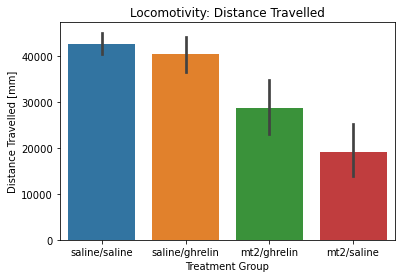

CPU times: user 439 ms, sys: 977 ms, total: 1.42 s
Wall time: 660 ms


In [8]:
%%time
import seaborn as sns

def get_distance_travelled(video):
    # Average the bodypart positions of the mouse to get its centroid 
    centroid = video.mouse_df.groupby(level='coords', axis=1).mean()
    
    # Get the between-frame movement of the bodyparts
    deltas = centroid[['x', 'y']].diff().dropna()
    
    # Calculate the total distance travelled 
    return np.sum(np.linalg.norm(deltas.values, axis=1))

distances = pd.Series(
    video_set.apply(get_distance_travelled),
    index=video_set.index, 
    name='distance')

sns.barplot(data=treatment_data.join(distances), x='injected_with', y='distance')
plt.xlabel("Treatment Group")
plt.ylabel("Distance Travelled [mm]")
plt.title("Locomotivity: Distance Travelled")
plt.show()

### Example 2: Heatmaps
Show what zones the mice are spending their time

#### Find position density

In [9]:
%%time
from tqdm import tqdm 
from scipy.stats.kde import gaussian_kde

groups = treatment_data.groupby(['treatment1', 'treatment2'])
w,h = config.box_shape

result = {}
for idx, group in tqdm(groups):
    group_videos = [video_set[video_set.index.index(idx)] for idx in group.index]
    
    # Stack the mouse-location dataframes for each mouse in this treatment group
    group_df = pd.concat([video.mouse_df for video in group_videos], axis=0).dropna()
    
    # Get the centroid of the mouse by averaging the bodypart positions in each frame
    centroid = group_df.groupby(level='coords', axis=1).mean()[['x', 'y']]
    data = centroid[['y', 'x']].values.T
    
    # Get the density of time spent in location (down sampled for 1 frame every 100)
    k = gaussian_kde(data[:,::100], )
    mgrid = np.mgrid[:h, :w]
    z = k(mgrid.reshape(2, -1))
    result['/'.join(idx)] = z

<timed exec>:2: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
100%|██████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.86s/it]

CPU times: user 12.3 s, sys: 4.22 s, total: 16.5 s
Wall time: 11.4 s


#### Create contour plots

CPU times: user 589 ms, sys: 50 ms, total: 639 ms
Wall time: 178 ms


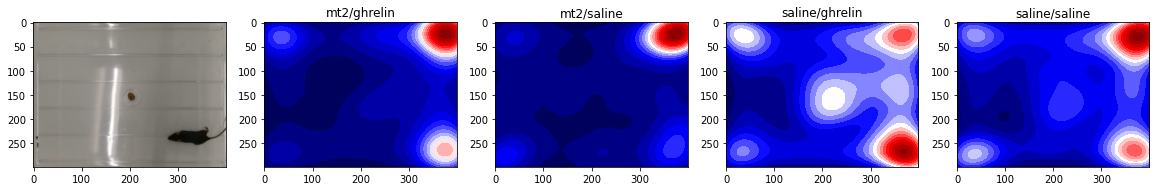

In [10]:
%%time
import matplotlib.pyplot as plt

CONTOUR_LEVELS = 20

video = video_set[0]
frame = video.get_frame(1000)

plt.figure(figsize=(20, 5))
gs = plt.GridSpec(1, 5)

plt.title("Box Reference")
plt.subplot(gs[0])
plt.imshow(frame)

for idx, (gname, z) in enumerate(result.items()):
    plt.subplot(gs[idx+1])
    plt.title(gname)
    plt.imshow(frame) # plotting a frame sets up the matplotlib axis correctly
    plt.imshow(z.reshape(mgrid.shape[1:]))
    plt.contourf(z.reshape(mgrid.shape[1:]), cmap='seismic', alpha=1, levels=CONTOUR_LEVELS)

### Example 3: Zone based analysis
Zones on can be drawn once in tools like napari, or automatically plotted

If the videos have been normalized, zones can be drawn once and applied to all videos

100%|███████████████████████████████████████████████████████| 72/72 [00:00<00:00, 185.93it/s]


CPU times: user 583 ms, sys: 309 ms, total: 892 ms
Wall time: 682 ms


Text(0.5, 1.0, 'Time in Zone')

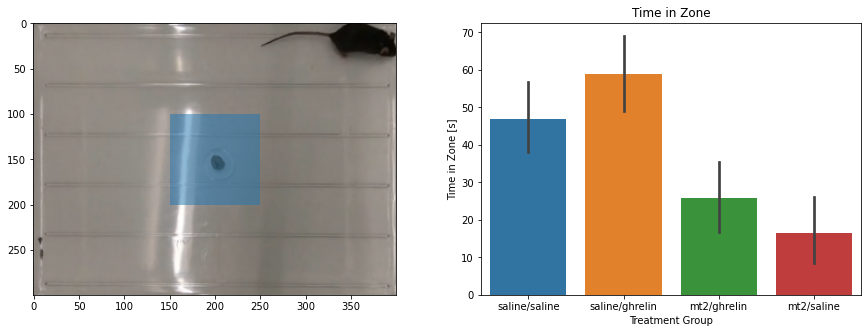

In [11]:
%%time
def get_center_zone(video):
    w,h = video_set[0].config.box_shape
    cx, cy = w//2, h//2
    s = 50
    return plt.Polygon([
        [cx-s, cy-s],
        [cx-s, cy+s],
        [cx+s, cy+s],
        [cx+s, cy-s]
    ], alpha=0.5, label='Center zone')
    
def time_in_zone(video):
    center_zone = get_center_zone(video)
    centroid = video.mouse_df.groupby(level='coords', axis=1).mean()[['x', 'y']].values
    return np.sum(center_zone.contains_points(centroid)) / video.fps


data = pd.Series(
    video_set.apply(time_in_zone),
    index=video_set.index, 
    name='time_in_center_zone')

plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 2)

plt.subplot(gs[0])
v = video_set[0]
plt.imshow(v.get_frame(900))
plt.gca().add_patch(get_center_zone(v))

plt.subplot(gs[1])
sns.barplot(data=treatment_data.join(data), x='injected_with', y='time_in_center_zone')
plt.xlabel("Treatment Group")
plt.ylabel("Time in Zone [s]")
plt.title("Time in Zone")